# Compare the performances of **two** sets of **three** Convolutional Neural Networks
*The CNNs in the same set share the same architecture but differ in their training/initialization schema.*
---



# Build the Neural Network
*(First Set of Components)*

---



**Import PyTorch libraries**

In [102]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Compose


## Get Device for Training
We want to be able to train our model on a hardware accelerator like the Graphics Processing Unit (GPU) or Multi-Process Service (MPS), if available. Let's check to see if torch.cuda or torch.backends.mps are available, otherwise we use the Central Processing Unit (CPU).                                                      

In [103]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


## Loading a Dataset
We load the [MNIST 2-D Dataset](https://pytorch.org/vision/main/datasets.html) with the following parameters:
* ```root``` is the path where the train/test data is stored,
* ```train``` specifies training or test dataset,
* ```transform``` specify the feature and label transformations,
* ```download=True``` downloads the data from the internet if it's not available at root.


In [104]:
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=Compose([ToTensor()]),
    download=True,
)
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=Compose([ToTensor()]),
    download=True)

## Using DataLoader
We create data loaders for training and testing data sets using the DataLoader class, which is responsible for iterating over a data set, providing the ability to batch access data. It takes a data set and batch size as arguments.

In our code, the packet size is set to 64, meaning that during training or testing, the data will be divided into packets, and each packet will contain 64 samples.

In [105]:
train_dataloader = DataLoader(train_dataset, batch_size=64) # batch_size is hyperparameter
test_dataloader = DataLoader(test_dataset, batch_size=64)

For demonstration, we generated a figure showing a grid of 25 randomly selected images from the MNIST training
dataset.

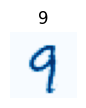

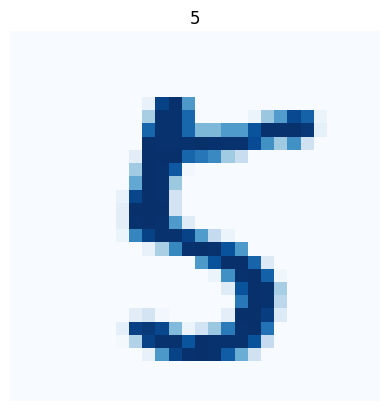

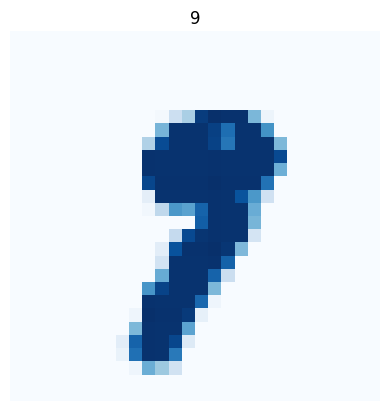

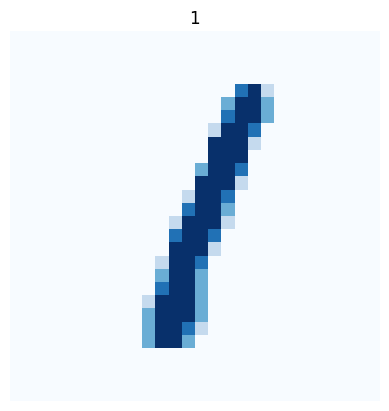

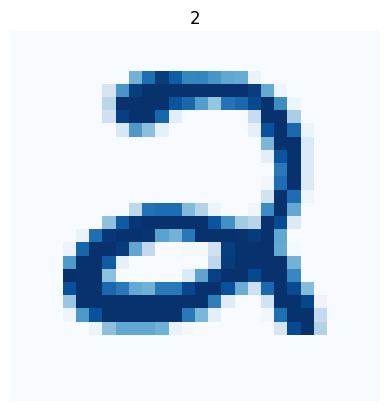

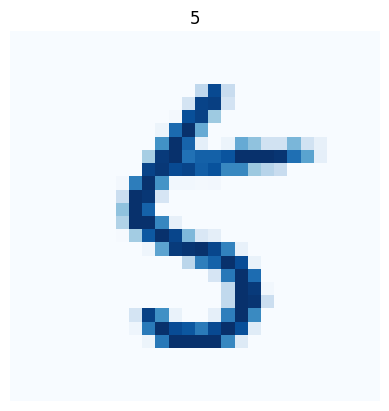

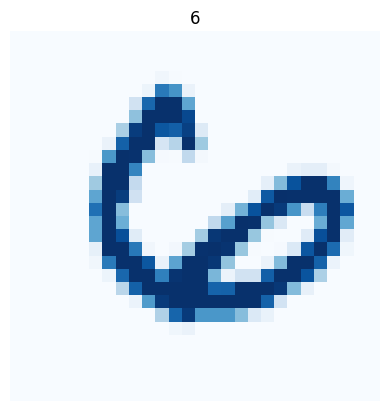

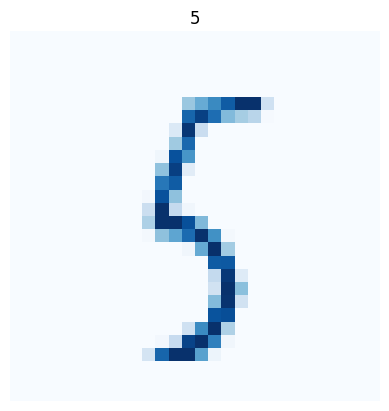

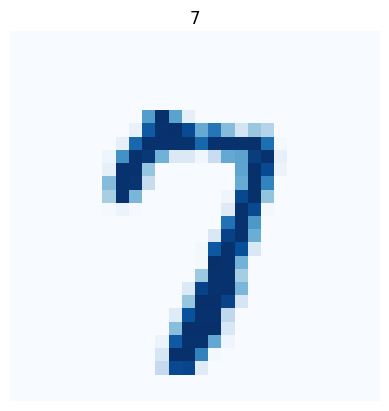

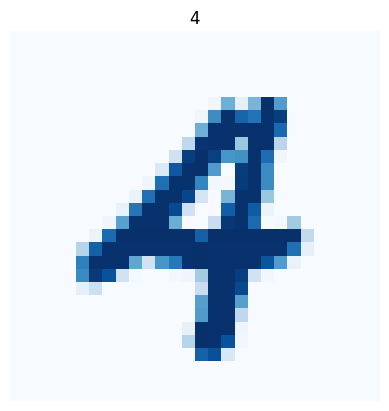

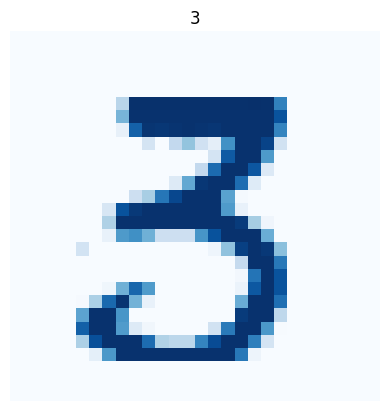

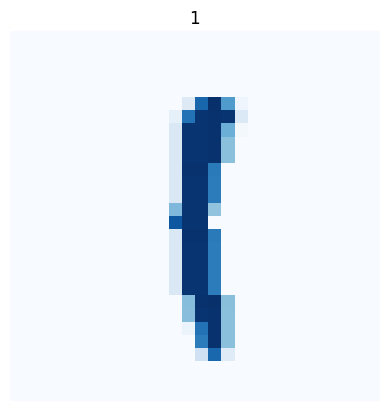

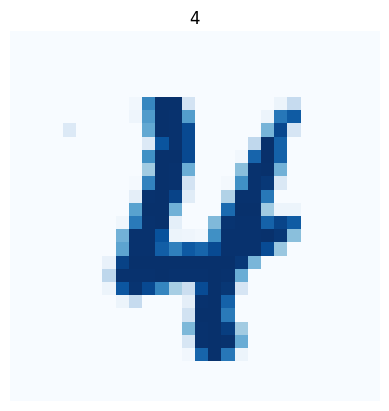

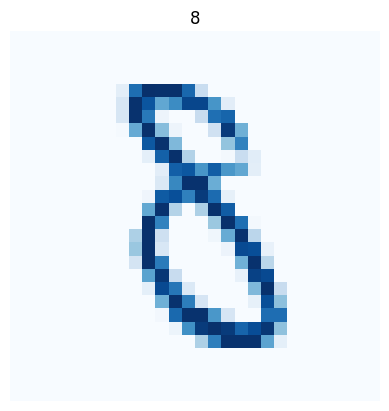

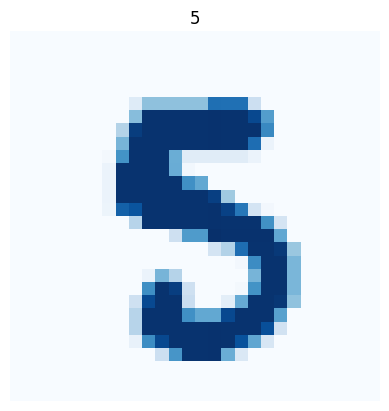

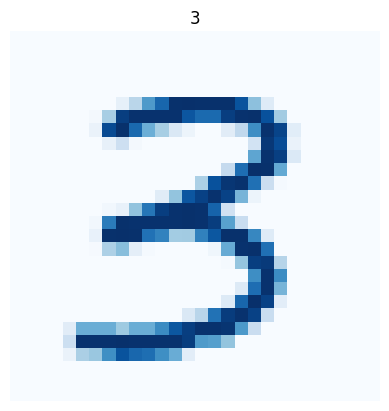

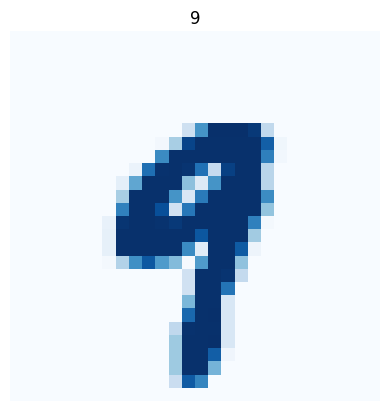

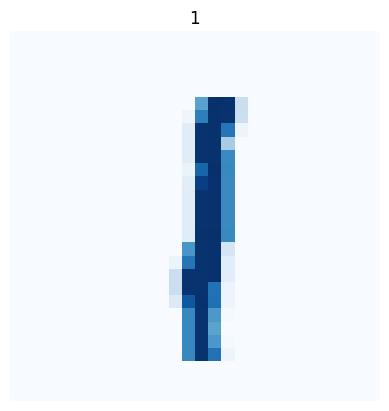

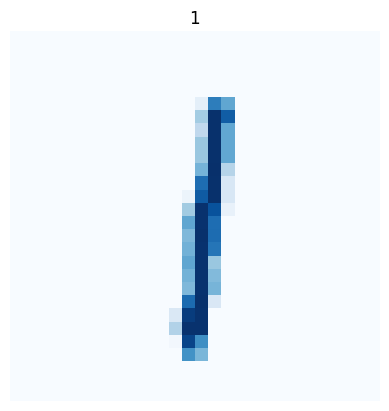

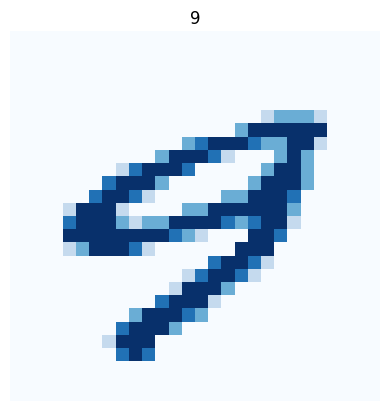

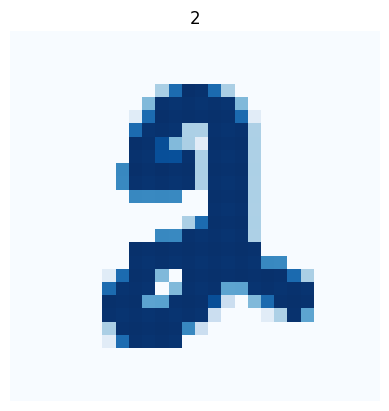

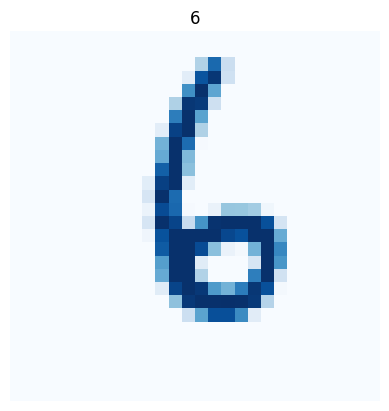

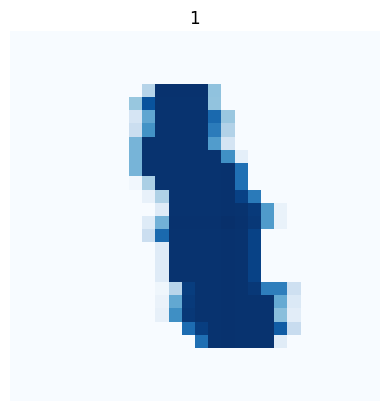

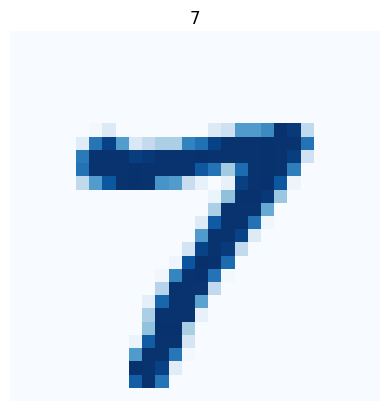

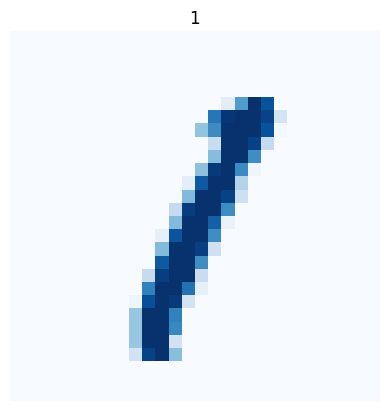

In [106]:
fig = plt. figure ( figsize =(7, 5))
cols , rows = 5, 5
for i in range (1, cols * rows + 1):
  sample_idx = torch.randint (len( train_dataset ) , size =(1 ,)). item ()
  img , label = train_dataset [ sample_idx ]
  fig.add_subplot (rows , cols , i)
  plt.title ( label )
  plt.axis ("off")
  plt.imshow (img. squeeze () , cmap ='Blues')
  plt.show ()

In [107]:
def plot_training_progress (losses , accuracies ):
 epochs = range (1, len( losses ) + 1)

 # Plotting losses
 plt. figure ( figsize =(10, 5))
 plt. subplot (1, 2, 1)
 plt. plot (epochs , losses , '-o')
 plt. xlabel ('Epoch')
 plt. ylabel ('Loss')
 plt. title ('Training Loss')

 # Plotting accuracies
 plt. subplot (1, 2, 2)
 plt. plot (epochs , accuracies , '-o')
 plt. xlabel ('Epoch')
 plt. ylabel ('Accuracy')
 plt. title ('Training Accuracy')

 plt. tight_layout () # Adjust the padding between and around subplots .
 plt. show ()


## Define the Class
We define our neural network by subclassing ```nn.Module```, and initialize the neural network layers in ```__init__```,
which is run once when an instance of a Dataset object is created. Every ```nn.Module``` subclass implements the operations on input data in the ```forward``` method.

In [108]:
class CNN_A1_(nn.Module):
  def __init__(self):
    super(CNN_A1_, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5) # One convolutional layer with 4 kernels
    self.relu1 = nn.ReLU()
    self.fc1 = nn.Linear(4 * 26 * 26, 10) # A fully connected layer
    self.relu2 = nn.ReLU()
    self.softmax = nn.Softmax(dim=1) # A final Softmaxoutput layer


  def forward(self, x):
    x = self.conv1(x) # The convolutional layer
    x = self.relu1(x) # Activation ReLU
    x = torch.flatten(x, 1) # The torch.flatten() function reshapes a tensor 'x'
    x = self.fc1(x) # Use fully connected layer
    x = self.relu2(x) # Activation second ReLU
    raw_output = self.softmax(x) # Softmax output
    return raw_output

We create an instance of `CNN_A1_`, and move it to the device, and print its structure.

In [109]:
model = CNN_A1_().to(device)
print(model)

CNN_A1_(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (fc1): Linear(in_features=2704, out_features=10, bias=True)
  (relu2): ReLU()
  (softmax): Softmax(dim=1)
)



We use the `initialization_hf` function to initialize the weights of the specified convolutional neural network (CNN) model using a predefined weight tensor.

The pre-defined  tensor called `weights` has a shape of `(4, 1, 3, 3)`, indicating 4 channels, 1 filter, and a filter size of 3x3.
The `weights` tensor is reshaped using the `view` method to match the shape expected by the model's convolutional layer.

Finally, the weights of the model's first convolutional layer (`model.conv1.weight`) are assigned the reshaped tensor as a `nn.Parameter` object. The `requires_grad=False` argument ensures that these weights are not updated during the training process and remain fixed.

In [110]:
def initialization_hf(model):
    with torch.no_grad():
      weights = torch.FloatTensor([[
          [1, 0, 0], [0, 1, 0], [0, 0, 1]],
          [[0, 0, 1], [0, 1, 0], [1, 0, 0]],
          [[0, 1, 0], [0, 1, 0], [0, 1, 0]],
          [[0, 0, 0], [1, 1, 1], [0, 0, 0]]])

    weights = weights.view(4, 1, 3, 3)

    model.conv1.weight = nn.Parameter(weights, requires_grad=False)

In [111]:
def initialization_ht(model):
    with torch.no_grad():
        weights = torch.FloatTensor([[
          [1, 0, 0], [0, 1, 0], [0, 0, 1]],
          [[0, 0, 1], [0, 1, 0], [1, 0, 0]],
          [[0, 1, 0], [0, 1, 0], [0, 1, 0]],
          [[0, 0, 0], [1, 1, 1], [0, 0, 0]]])
        bias = torch.FloatTensor([0, 0, 0, 0])

        weights = weights.view(4, 1, 3, 3)
        bias = bias.view(4)

        model.conv1.weight = nn.Parameter(weights, requires_grad=True)
        model.conv1.bias = nn.Parameter(bias, requires_grad=True)

In [112]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight.data)
            nn.init.normal_(m.bias.data, 0, 1)

        torch.save({"CNN_default_weights": model.state_dict()}, "CNN_default_weights.pt")

## Loss Function
To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include ```nn.MSELoss``` (Mean Square Error) for regression tasks, and [nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) (Negative Log Likelihood) for classification. [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) combines ```nn.LogSoftmax``` and ```nn.NLLLoss```.

We pass our model's output logits to ```nn.CrossEntropyLoss```, which will normalize the logits and compute the prediction error.

In [113]:
loss_fn = nn.CrossEntropyLoss()  # Initialize the loss function

We instantiate a CNN model called `cnn1` using the `CNN_A1_` class and initialize its weights using the `initialization_hf` function.

In [114]:
cnn1 = CNN_A1_()
initialization_hf(cnn1)
cnn1

CNN_A1_(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (fc1): Linear(in_features=2704, out_features=10, bias=True)
  (relu2): ReLU()
  (softmax): Softmax(dim=1)
)

In [115]:
cnn2 = CNN_A1_()
initialization_ht(cnn2)
cnn2

CNN_A1_(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (fc1): Linear(in_features=2704, out_features=10, bias=True)
  (relu2): ReLU()
  (softmax): Softmax(dim=1)
)

In [116]:
cnn3 = CNN_A1_()
initialization_ht(cnn3)
cnn3

CNN_A1_(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (fc1): Linear(in_features=2704, out_features=10, bias=True)
  (relu2): ReLU()
  (softmax): Softmax(dim=1)
)

## Learning Rate
Hyperparameter of the number of model parameter updates in each batch/epoch. Smaller values ​​result in slower learning rates, while larger values ​​can cause unpredictable learning behavior.


In [117]:
learning_rate = 1e-3

## Wrapping it up
We define `train_loop` that performs the training loop, and `test_loop` that used for evaluating the trained model on a test dataset.

In [118]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  # torch save model with torch.save()
  torch.save({'model_weights': model.state_dict()}, 'model.pt')

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to `train_loop` and `test_loop`. The number of epochs to track the model's improving performance is equal to 20 (more is possible, but not too much).

#### 1 Start

In [119]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn1.parameters(), lr=learning_rate)

epochs = 20
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, cnn1, loss_fn, optimizer)
  test_loop(test_dataloader, cnn1, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302911  [   64/60000]
loss: 2.271461  [ 6464/60000]
loss: 2.250852  [12864/60000]
loss: 2.275051  [19264/60000]
loss: 2.190306  [25664/60000]
loss: 2.129449  [32064/60000]
loss: 2.089328  [38464/60000]
loss: 2.136639  [44864/60000]
loss: 2.193471  [51264/60000]
loss: 2.068185  [57664/60000]
Test Error: 
 Accuracy: 37.2%, Avg loss: 2.108708 

Epoch 2
-------------------------------
loss: 2.149277  [   64/60000]
loss: 2.102182  [ 6464/60000]
loss: 1.978000  [12864/60000]
loss: 2.213117  [19264/60000]
loss: 2.081482  [25664/60000]
loss: 2.048480  [32064/60000]
loss: 2.024920  [38464/60000]
loss: 2.080940  [44864/60000]
loss: 2.164252  [51264/60000]
loss: 2.041754  [57664/60000]
Test Error: 
 Accuracy: 38.1%, Avg loss: 2.084791 

Epoch 3
-------------------------------
loss: 2.124024  [   64/60000]
loss: 2.082628  [ 6464/60000]
loss: 1.948876  [12864/60000]
loss: 2.201737  [19264/60000]
loss: 2.071115  [25664/60000]
loss: 2.036786  [32064/600

### 2 Strat

In [120]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn2.parameters(), lr=learning_rate)

epochs = 20
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, cnn2, loss_fn, optimizer)
  test_loop(test_dataloader, cnn2, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.308938  [   64/60000]
loss: 2.275506  [ 6464/60000]
loss: 2.159400  [12864/60000]
loss: 2.093465  [19264/60000]
loss: 2.105666  [25664/60000]
loss: 2.047309  [32064/60000]
loss: 1.975531  [38464/60000]
loss: 1.973460  [44864/60000]
loss: 1.994943  [51264/60000]
loss: 1.897209  [57664/60000]
Test Error: 
 Accuracy: 66.7%, Avg loss: 1.907669 

Epoch 2
-------------------------------
loss: 1.982110  [   64/60000]
loss: 1.887056  [ 6464/60000]
loss: 1.847401  [12864/60000]
loss: 1.899178  [19264/60000]
loss: 1.842861  [25664/60000]
loss: 1.820821  [32064/60000]
loss: 1.821139  [38464/60000]
loss: 1.808951  [44864/60000]
loss: 1.910057  [51264/60000]
loss: 1.796528  [57664/60000]
Test Error: 
 Accuracy: 70.2%, Avg loss: 1.821312 

Epoch 3
-------------------------------
loss: 1.893055  [   64/60000]
loss: 1.824217  [ 6464/60000]
loss: 1.769266  [12864/60000]
loss: 1.865280  [19264/60000]
loss: 1.788487  [25664/60000]
loss: 1.782029  [32064/600

### 3 Start

In [121]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn3.parameters(), lr=learning_rate)

epochs = 20
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, cnn3, loss_fn, optimizer)
  test_loop(test_dataloader, cnn3, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299391  [   64/60000]
loss: 2.255089  [ 6464/60000]
loss: 2.262599  [12864/60000]
loss: 2.166980  [19264/60000]
loss: 2.133385  [25664/60000]
loss: 2.070436  [32064/60000]
loss: 2.040009  [38464/60000]
loss: 2.077262  [44864/60000]
loss: 2.056740  [51264/60000]
loss: 1.951091  [57664/60000]
Test Error: 
 Accuracy: 48.4%, Avg loss: 2.004866 

Epoch 2
-------------------------------
loss: 2.034762  [   64/60000]
loss: 1.996368  [ 6464/60000]
loss: 1.983899  [12864/60000]
loss: 1.995948  [19264/60000]
loss: 1.982740  [25664/60000]
loss: 1.949142  [32064/60000]
loss: 1.954796  [38464/60000]
loss: 1.928476  [44864/60000]
loss: 2.005379  [51264/60000]
loss: 1.905734  [57664/60000]
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.932157 

Epoch 3
-------------------------------
loss: 1.993173  [   64/60000]
loss: 1.911001  [ 6464/60000]
loss: 1.862146  [12864/60000]
loss: 1.983288  [19264/60000]
loss: 1.929139  [25664/60000]
loss: 1.895271  [32064/600

## Define the Class
We define our neural network by subclassing ```nn.Module```, and initialize the neural network layers in ```__init__```,
which is run once when an instance of a Dataset object is created. Every ```nn.Module``` subclass implements the operations on input data in the ```forward``` method.

In [122]:
class CNN_A2_(nn.Module):
  def __init__(self):
    super(CNN_A2_, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3)#filter size 1x5x5
    self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3) #filter size 4x3x3x
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(8*24*24, 10) # A fully connected layer
    self.softmax = nn.Softmax(dim=1) # A final Softmax output layer

  def forward(self, x):
    x = self.relu(self.conv1(x)) # The convolutional layer 1
    x = self.relu(self.conv2(x)) # The convolutional layer 2
    x = self.flatten(x) # The torch.flatten() function reshapes a tensor 'x'
    raw_output = self.softmax(x) # Softmax output

    return raw_output

We create an instance of `CNN_A2_` , and move it to the device, and print its structure.

In [123]:
model = CNN_A2_().to(device)
print(model)

CNN_A2_(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4608, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


We use the initialization_hf function to initialize the weights of the specified convolutional neural network (CNN) model using a predefined weight tensor.

The pre-defined tensor called weights has a shape of (4, 1, 3, 3), indicating 4 channels, 1 filter, and a filter size of 3x3. The weights tensor is reshaped using the view method to match the shape expected by the model's convolutional layer.

Finally, the weights of the model's first convolutional layer (model.conv1.weight) are assigned the reshaped tensor as a nn.Parameter object. The requires_grad=False argument ensures that these weights are not updated during the training process and remain fixed.

We instantiate a CNN model called `cnn4` using the `CNN_A2_` class and initialize its weights using the `initialization_hf` function.

In [124]:
cnn4 = CNN_A2_()
initialization_hf(cnn4)
cnn4

CNN_A2_(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4608, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

We instantiate a CNN model called `cnn5` using the `CNN_A2_` class and initialize its weights using the `initialization_ht` function.

In [125]:
cnn5 = CNN_A2_()
initialization_ht(cnn5)
cnn5

CNN_A2_(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4608, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

We instantiate a CNN model called `cnn6` using the `CNN_A2_` class and  initializes its weights and biases using a custom `init_weights` function.

In [126]:
cnn6 = CNN_A2_()
cnn6.apply(init_weights)
cnn6

CNN_A2_(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4608, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

## Loss Function

In [127]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn4.parameters(), lr=learning_rate)

epochs = 20
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, cnn4, loss_fn, optimizer)
  test_loop(test_dataloader, cnn4, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 8.435566  [   64/60000]
loss: 8.435566  [ 6464/60000]
loss: 8.435564  [12864/60000]
loss: 8.435568  [19264/60000]
loss: 8.435566  [25664/60000]
loss: 8.435567  [32064/60000]
loss: 8.435566  [38464/60000]
loss: 8.435565  [44864/60000]
loss: 8.435569  [51264/60000]
loss: 8.435566  [57664/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 8.435566 

Epoch 2
-------------------------------
loss: 8.435566  [   64/60000]
loss: 8.435566  [ 6464/60000]
loss: 8.435565  [12864/60000]
loss: 8.435568  [19264/60000]
loss: 8.435566  [25664/60000]
loss: 8.435567  [32064/60000]
loss: 8.435565  [38464/60000]
loss: 8.435565  [44864/60000]
loss: 8.435568  [51264/60000]
loss: 8.435566  [57664/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 8.435566 

Epoch 3
-------------------------------
loss: 8.435566  [   64/60000]
loss: 8.435566  [ 6464/60000]
loss: 8.435565  [12864/60000]
loss: 8.435568  [19264/60000]
loss: 8.435566  [25664/60000]
loss: 8.435567  [32064/60000

In [128]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn5.parameters(), lr=learning_rate)

epochs = 20
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, cnn5, loss_fn, optimizer)
  test_loop(test_dataloader, cnn5, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 8.435583  [   64/60000]
loss: 8.435586  [ 6464/60000]
loss: 8.435579  [12864/60000]
loss: 8.435590  [19264/60000]
loss: 8.435580  [25664/60000]
loss: 8.435585  [32064/60000]
loss: 8.435580  [38464/60000]
loss: 8.435580  [44864/60000]
loss: 8.435589  [51264/60000]
loss: 8.435581  [57664/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 8.435584 

Epoch 2
-------------------------------
loss: 8.435584  [   64/60000]
loss: 8.435586  [ 6464/60000]
loss: 8.435579  [12864/60000]
loss: 8.435590  [19264/60000]
loss: 8.435581  [25664/60000]
loss: 8.435586  [32064/60000]
loss: 8.435581  [38464/60000]
loss: 8.435579  [44864/60000]
loss: 8.435589  [51264/60000]
loss: 8.435582  [57664/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 8.435584 

Epoch 3
-------------------------------
loss: 8.435583  [   64/60000]
loss: 8.435586  [ 6464/60000]
loss: 8.435579  [12864/60000]
loss: 8.435590  [19264/60000]
loss: 8.435581  [25664/60000]
loss: 8.435585  [32064/60000

In [129]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn6.parameters(), lr=learning_rate)

epochs = 20
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, cnn6, loss_fn, optimizer)
  test_loop(test_dataloader, cnn6, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 8.435790  [   64/60000]
loss: 8.435800  [ 6464/60000]
loss: 8.435804  [12864/60000]
loss: 8.435804  [19264/60000]
loss: 8.435799  [25664/60000]
loss: 8.435801  [32064/60000]
loss: 8.435798  [38464/60000]
loss: 8.435803  [44864/60000]
loss: 8.435814  [51264/60000]
loss: 8.435802  [57664/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 8.435800 

Epoch 2
-------------------------------
loss: 8.435790  [   64/60000]
loss: 8.435800  [ 6464/60000]
loss: 8.435804  [12864/60000]
loss: 8.435802  [19264/60000]
loss: 8.435799  [25664/60000]
loss: 8.435800  [32064/60000]
loss: 8.435799  [38464/60000]
loss: 8.435803  [44864/60000]
loss: 8.435813  [51264/60000]
loss: 8.435803  [57664/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 8.435800 

Epoch 3
-------------------------------
loss: 8.435790  [   64/60000]
loss: 8.435800  [ 6464/60000]
loss: 8.435804  [12864/60000]
loss: 8.435804  [19264/60000]
loss: 8.435799  [25664/60000]
loss: 8.435800  [32064/60000